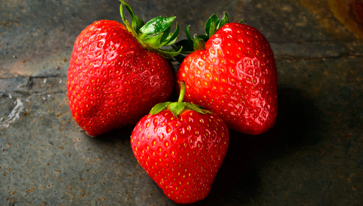


Photo by <a href="https://unsplash.com/@dylu?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Jacek Dylag</a> on <a href="https://unsplash.com/s/photos/strawberry?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

# Presentation  
Hello everyone.  
In today's work we will learn how to apply tensorflow machine learning algorithms to detect adulteration in strawberry samples from the infrared spectra.    
Don't worry if you're not familiar with the topic, we'll explain you everything in detail.

# Introduction

When purchasing fruit purees or juices, the potential problem of adulteration has to be considered. The practice of adulteration arises for two main reasons: Firstly it can be proftable, as certain fruits command premium prices; and secondly adulterants can be easily mixed into a puree e or juice, and are subsequently difficult to
detect.(https://doi.org/10.1002/(SICI)1097-0010(199802)76:2%3C263::AID-JSFA943%3E3.0.CO;2-F)

The purpose of this notebook is to create a classifier model for detection of adulteration in strawberry puree samples from its infrared spectra (FT-IR), using tensorflow decision forest algorithm.   

Moreover, to make our features more suitable, we will demonstrate the use of tensorflow autoencoder network to reduce infrared spectrum dimensionality.   

The dataset employed was made available by the Quadram Institute, which was part of work published by Holland et al. (1998). In this paper the author proposed a model of detection of adulteration in this dataset using the least squares partial regression (PLS) technique.   

The dataset was obtained from the address below, and is part of the paper:

Holland, J. K., Kemsley, E. K., & Wilson, R. H. (1998). Use of Fourier transform infrared spectroscopy and partial least squares regression for the detection of adulteration of strawberry purees. Journal of the Science of Food and Agriculture, 76(2), 263-269

and it can be downloaded from
http://csr.quadram.ac.uk/wp-content/uploads/MIRFruitPurees.zip

This dataset consists of spectra of 983 fruit purees (pure and adulterated).

### Our pipeline
In summary, our work will be divided into 3 main parts:  

* Dataset and feature engineering
* Autoencoder to reduce infrared spectrum dimensionality
* Decicion forest for classification

### Infrared spectroscopy - what is it?

The light our eyes see is but a small part of a broad spectrum of electromagnetic radiation. On the immediate high energy side of the visible spectrum lies the ultraviolet, and on the low energy side is the infrared. The portion of the infrared region most useful for analysis of organic compounds is not immediately adjacent to the visible spectrum, but is that having a wavelength range from 2,500 to 16,000 nm, with a corresponding frequency range from 1.9x10E13 to 1.2x10E14 Hz.(https://www2.chemistry.msu.edu/faculty/reusch/virttxtjml/spectrpy/infrared/infrared.htm)   

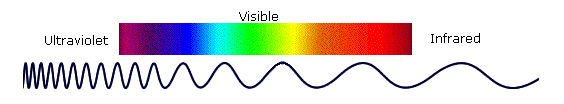    
Image from: https://www2.chemistry.msu.edu/faculty/reusch/virttxtjml/spectrpy/infrared/infrared.htm    


The infrared portion of the electromagnetic spectrum is usually divided into three regions; the near-, mid- and far- infrared, named for their relation to the visible spectrum.   
Infrared spectroscopy (IR spectroscopy or vibrational spectroscopy) is the measurement of the interaction of infrared radiation with matter by absorption, emission, or reflection. It is used to study and identify chemical substances or functional groups in solid, liquid, or gaseous forms. It can be used to characterize new materials or identify and verify known and unknown samples.     
The method or technique of infrared spectroscopy is conducted with an instrument called an infrared spectrometer (or spectrophotometer) which produces an infrared spectrum. An IR spectrum can be visualized in a graph of infrared light absorbance (or transmittance) on the vertical axis vs. frequency or wavelength on the horizontal axis. Typical units of frequency used in IR spectra are reciprocal centimeters (sometimes called wave numbers), with the symbol cm−1. Units of IR wavelength are commonly given in micrometers (formerly called "microns"), symbol μm, which are related to wave numbers in a reciprocal way.    
A common laboratory instrument that uses this technique is a Fourier transform infrared (FTIR) spectrometer.     
Infrared spectroscopy exploits the fact that molecules absorb frequencies characteristic of their structure, and for this reason, infrared spectroscopy is a simple and reliable technique widely used in both organic and inorganic chemistry, research and industry.    
An important application of Infrared Spectroscopy is in the food industry to measure the concentration of various compounds, or to assess the degree of contamination, in different food products.(https://en.wikipedia.org/wiki/Infrared_spectroscopy)   

An example of infrared spectrum of the flavoring agent vanillin, shown below.   

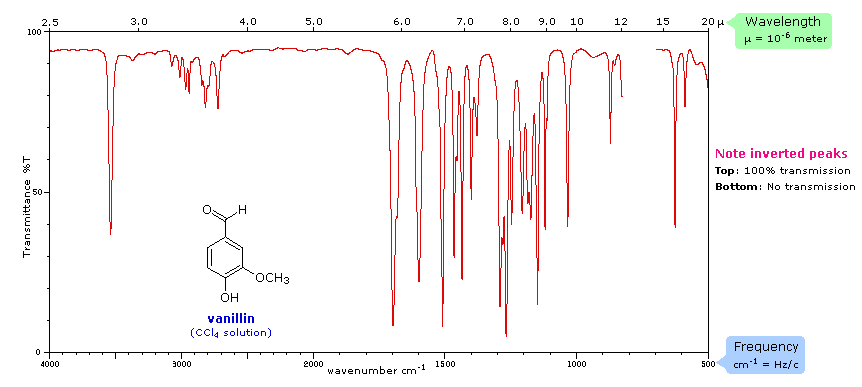   
Image from:  
https://www2.chemistry.msu.edu/faculty/reusch/virttxtjml/spectrpy/infrared/infrared.htm   


### Installing libraries

First, let's install and import the necessary libraries.

In [1]:
import tensorflow_decision_forests as tfdf

2024-02-06 17:38:50.327984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 17:38:50.328045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 17:38:50.379670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-06 17:38:50.485194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 17:38:52.021510: W tensorflow/compiler/tf2

In [2]:
from datetime import datetime
from packaging import version
from IPython import display
import numpy as np 
import pandas as pd 
import math
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError


In [3]:
# Check and assert the tensorflow version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.15.0


In [4]:
# Filter warnings
import warnings 
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Dataset
The dataset was obtained from the address below, and is part of the paper:

Holland, J. K., Kemsley, E. K., & Wilson, R. H. (1998). Use of Fourier transform infrared spectroscopy and partial least squares regression for the detection of adulteration of strawberry purees. Journal of the Science of Food and Agriculture, 76(2), 263-269

http://csr.quadram.ac.uk/wp-content/uploads/MIRFruitPurees.zip

In [5]:
# my dataset file path
filePath = 'data/MIR_Fruit_purees.csv'

If you haven't downloaded the dataset just remove the comments below.

In [7]:
# Download and unzip the dataset
# !wget http://csr.quadr/am.ac.uk/wp-content/uploads/MIRFruitPurees.zip
# !ls -l MIRFruitPurees.zip
# !unzip  MIRFruitPurees.zip
# filePath = 'MIR_Fruit_purees.csv'

In [6]:
base0 = pd.read_csv(filePath)
base0

,Wavenumbers,NON-Strawberry,NON-Strawberry.1,NON-Strawberry.2,NON-Strawberry.3,NON-Strawberry.4,NON-Strawberry.5,NON-Strawberry.6,NON-Strawberry.7,NON-Strawberry.8,...,NON-Strawberry.622,NON-Strawberry.623,NON-Strawberry.624,NON-Strawberry.625,NON-Strawberry.626,NON-Strawberry.627,NON-Strawberry.628,NON-Strawberry.629,NON-Strawberry.630,NON-Strawberry.631
0,899.327,0.002806,0.002637,0.002416,0.002345,0.002303,0.002514,0.002105,0.002018,0.002154,...,0.002539,0.002569,0.002723,0.002542,0.002627,0.002631,2.730378e-03,0.002713,0.002697,0.002789
1,903.187,0.002732,0.002638,0.002480,0.002292,0.002342,0.002488,0.002078,0.001999,0.002165,...,0.002507,0.002569,0.002714,0.002539,0.002629,0.002651,2.838751e-03,0.002779,0.002905,0.003040
2,907.047,0.002661,0.002651,0.002511,0.002249,0.002350,0.002477,0.002077,0.001945,0.002191,...,0.002483,0.002541,0.002740,0.002574,0.002619,0.002696,2.999267e-03,0.002877,0.003277,0.003359
3,910.907,0.002657,0.002757,0.002611,0.002303,0.002419,0.002542,0.002154,0.001964,0.002275,...,0.002563,0.002599,0.002861,0.002664,0.002714,0.002809,3.258967e-03,0.003085,0.003711,0.003796
4,914.767,0.002699,0.003000,0.002802,0.002466,0.002561,0.002713,0.002311,0.002083,0.002470,...,0.002764,0.002806,0.003090,0.002829,0.002939,0.003022,3.649444e-03,0.003419,0.004265,0.004394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1787.124,0.000087,-0.000006,0.000062,0.000075,0.000099,0.000054,0.000064,0.000102,0.000081,...,0.000004,0.000008,0.000008,0.000005,0.000012,-0.000001,-7.710620e-07,0.000007,-0.000009,-0.000020
231,1790.984,0.000046,0.000002,0.000031,0.000043,0.000054,0.000031,0.000043,0.000064,0.000055,...,0.000007,0.000018,0.000010,0.000007,0.000012,0.000003,2.049950e-07,0.000007,-0.000005,-0.000006
232,1794.844,0.000011,0.000010,0.000009,0.000021,0.000020,0.000016,0.000027,0.000038,0.000033,...,0.000014,0.000014,0.000015,0.000013,0.000010,0.000007,6.586780e-06,0.000012,-0.000002,-0.000005
233,1798.704,0.000009,0.000005,0.000007,0.000008,0.000012,0.000008,0.000012,0.000015,0.000014,...,0.000011,0.000011,0.000010,0.000010,0.000006,0.000008,5.125220e-06,0.000013,0.000001,-0.000002



Now we need to make some adjustments to the column names and some changes to the dataset.   
As we mentioned earlier, this dataset consists of infrared spectra of 983 fruit purees (pure and adulterated).  
The first column represents the spectra wave number, and the subsequent columns represent the respective absorbance values for each strawberry sample.   
More information you can refer to the paper   
Holland, J. K., Kemsley, E. K., & Wilson, R. H. (1998). Use of Fourier transform infrared spectroscopy and partial least squares regression for the detection of adulteration of strawberry purees. Journal of the Science of Food and Agriculture, 76(2), 263-269

In [7]:
# Our dataframe

lista = list(base0.columns)
# Changing column names to avoid error with '-'
lista = [i.replace('-','_') for i in lista]
base0.columns = lista
base0.head()

,Wavenumbers,NON_Strawberry,NON_Strawberry.1,NON_Strawberry.2,NON_Strawberry.3,NON_Strawberry.4,NON_Strawberry.5,NON_Strawberry.6,NON_Strawberry.7,NON_Strawberry.8,...,NON_Strawberry.622,NON_Strawberry.623,NON_Strawberry.624,NON_Strawberry.625,NON_Strawberry.626,NON_Strawberry.627,NON_Strawberry.628,NON_Strawberry.629,NON_Strawberry.630,NON_Strawberry.631
0,899.327,0.002806,0.002637,0.002416,0.002345,0.002303,0.002514,0.002105,0.002018,0.002154,...,0.002539,0.002569,0.002723,0.002542,0.002627,0.002631,0.002730,0.002713,0.002697,0.002789
1,903.187,0.002732,0.002638,0.002480,0.002292,0.002342,0.002488,0.002078,0.001999,0.002165,...,0.002507,0.002569,0.002714,0.002539,0.002629,0.002651,0.002839,0.002779,0.002905,0.003040
2,907.047,0.002661,0.002651,0.002511,0.002249,0.002350,0.002477,0.002077,0.001945,0.002191,...,0.002483,0.002541,0.002740,0.002574,0.002619,0.002696,0.002999,0.002877,0.003277,0.003359
3,910.907,0.002657,0.002757,0.002611,0.002303,0.002419,0.002542,0.002154,0.001964,0.002275,...,0.002563,0.002599,0.002861,0.002664,0.002714,0.002809,0.003259,0.003085,0.003711,0.003796
4,914.767,0.002699,0.003000,0.002802,0.002466,0.002561,0.002713,0.002311,0.002083,0.002470,...,0.002764,0.002806,0.003090,0.002829,0.002939,0.003022,0.003649,0.003419,0.004265,0.004394


Here, we will plot some spectra of adulterated and unadulterated samples, to know that.

In [15]:
base0.shape

(235, 984)

<Axes: xlabel='Wavenumbers', ylabel='value'>

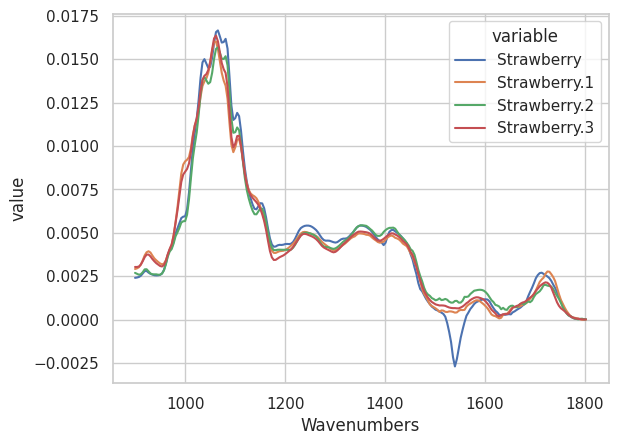

In [11]:
# Plotting some spectra of pure strawberry pulps
data = base0.filter(regex=("^(?!NON)"), axis=1)
data = data.iloc[:,0:5]
sns.lineplot(x='Wavenumbers', y='value', hue='variable', data=pd.melt(data, ['Wavenumbers']))

<Axes: xlabel='Wavenumbers', ylabel='value'>

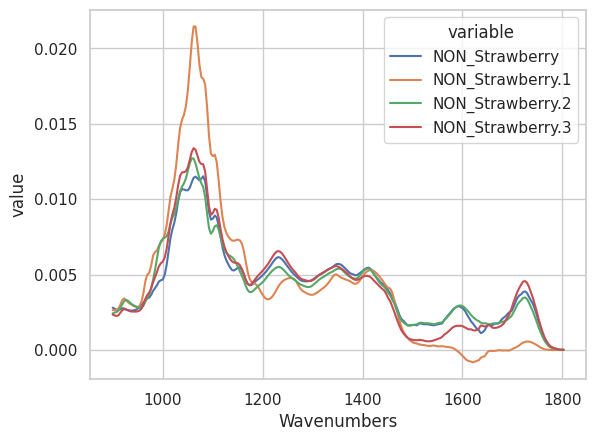

In [17]:
# Plotting some spectra of adulterated strawberry (non-strawberry) pulp
data = base0.iloc[:,0:5]
sns.lineplot(x='Wavenumbers', y='value', hue='variable', 
             data=pd.melt(data, ['Wavenumbers']))

## Feature engineering
Now that we've seen what IR spectra look like, we'll have to do some transformations and transpose the dataframe to make it suitable for machine learning tools. After that, each sample will be in rows.

In [41]:
# Dataframe transpose
df = base0.T
df.columns = df.iloc[0]
base = df[1:]

# Setting dataframe index
base.reset_index(inplace=True)
base.index.names = ['index']
base.columns.names = ['columns']
base = base.rename(columns={'index': 'Samples'})

# Setting labels
base['Label'] = np.where(base.Samples.str.contains('NON'), "0", "1")

# Selecting features
X = base.drop('Samples', axis = 1)
X = X.drop('Label', axis = 1)
y = base['Label']
X.head(3)

columns,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1767.824,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564
index,,,,,,,,,,,,,,,,,,,,,
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000562,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000022,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005
2,0.002416,0.002480,0.002511,0.002611,0.002802,0.003031,0.003235,0.003316,0.003257,0.003136,...,0.000449,0.000290,0.000185,0.000137,0.000090,0.000062,0.000031,0.000009,0.000007,0.000007


In [42]:
y.head()

index
0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: object

In [43]:
# Counting how many samples classified as pure strawberry (1) and non strawberry (0) 
y.value_counts()

Label
0    632
1    351
Name: count, dtype: int64

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Columns: 235 entries, 899.327 to 1802.564
dtypes: float64(235)
memory usage: 1.8 MB


In [47]:
X.describe()

columns,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1767.824,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564
count,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,...,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000,983.000000
mean,0.002450,0.002465,0.002495,0.002604,0.002811,0.003044,0.003176,0.003174,0.003096,0.002994,...,0.000313,0.000218,0.000139,0.000092,0.000062,0.000041,0.000029,0.000019,0.000009,0.000008
std,0.000342,0.000351,0.000383,0.000428,0.000495,0.000596,0.000710,0.000792,0.000790,0.000718,...,0.000211,0.000159,0.000122,0.000100,0.000078,0.000059,0.000039,0.000026,0.000011,0.000011
min,0.001391,0.001389,0.001371,0.001472,0.001585,0.001667,0.001738,0.001754,0.001791,0.001836,...,-0.000069,-0.000072,-0.000061,-0.000050,-0.000049,-0.000084,-0.000023,-0.000055,-0.000014,-0.000014
25%,0.002227,0.002226,0.002239,0.002313,0.002478,0.002642,0.002684,0.002633,0.002554,0.002505,...,0.000174,0.000118,0.000067,0.000038,0.000023,0.000014,0.000013,0.000007,0.000004,0.000002
50%,0.002449,0.002469,0.002494,0.002592,0.002779,0.002969,0.003054,0.003025,0.002948,0.002856,...,0.000279,0.000192,0.000116,0.000074,0.000048,0.000031,0.000022,0.000014,0.000008,0.000007
75%,0.002711,0.002728,0.002776,0.002916,0.003165,0.003427,0.003590,0.003601,0.003502,0.003362,...,0.000412,0.000286,0.000183,0.000121,0.000079,0.000058,0.000036,0.000024,0.000012,0.000011
max,0.003317,0.003450,0.003648,0.003943,0.004506,0.005230,0.005935,0.006418,0.006391,0.005979,...,0.001555,0.001495,0.001423,0.001319,0.001122,0.000889,0.000644,0.000380,0.000187,0.000187


To make the dataset suitable for the autoencoder network, we will standardize the scale.

In [48]:
# Converting the dataframe to standard scale
scaler_x = StandardScaler()
X_std = scaler_x.fit_transform(X)
X_std = pd.DataFrame(X_std, columns = X.columns)
X_std.head(3)

columns,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1767.824,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564
0,1.041688,0.761435,0.433940,0.124319,-0.227707,-0.473674,-0.601727,-0.617253,-0.581059,-0.526530,...,1.179813,0.817552,0.635120,0.740000,0.707549,0.778570,0.421520,-0.301741,0.029411,0.091422
1,0.549737,0.494795,0.408431,0.358937,0.381186,0.452014,0.333839,0.161408,0.083609,0.090894,...,-1.384657,-1.290717,-1.089593,-0.970303,-0.864345,-0.784020,-0.700196,-0.346303,-0.360891,-0.291226
2,-0.098423,0.042790,0.040923,0.017364,-0.018962,-0.022629,0.083383,0.179372,0.204355,0.197133,...,0.646567,0.455783,0.383649,0.446432,0.366885,0.359533,0.046427,-0.378467,-0.172976,-0.106996


As our dataset has 235 features (wavenumbers) let's apply a dimensionality reduction technique, and reduce the number of features.

# Dimensionality reduction with Autoencoder

High-dimensional data can be converted to low-dimensional codes by training a multilayer neural network with a small central layer to reconstruct high-dimensional input vectors. Hinton, G. E., & Salakhutdinov, R. R. (2006).    

Autoencoders:   
An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. https://www.tensorflow.org/tutorials/generative/autoencoder   
An autoencoder has two main parts: an encoder that maps the input into the code, and a decoder that maps the code to a reconstruction of the input. 
The simplest way to perform the copying task perfectly would be to duplicate the signal. Instead, autoencoders are typically forced to reconstruct the input approximately, preserving only the most relevant aspects of the data in the copy. https://en.wikipedia.org/wiki/Autoencoder  
 
Schematic structure of an autoencoder with 3 fully connected hidden layers. 


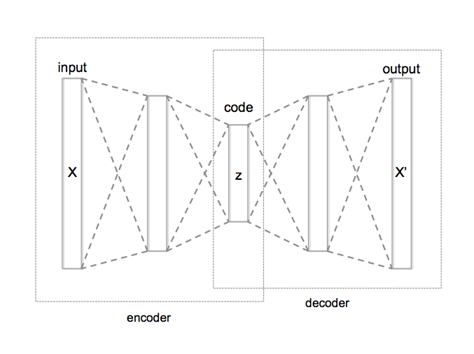


https://en.wikipedia.org/wiki/Autoencoder#Dimensionality_reduction  


The two main applications of autoencoders are dimensionality reduction and information retrieval, but modern variations have been applied to other tasks.  
References:   
https://en.wikipedia.org/wiki/Autoencoder    
Goodfellow, Ian; Bengio, Yoshua; Courville, Aaron (2016). Deep Learning. MIT Press. ISBN 978-0262035613.    

In this paper we will use an autoencoder network to reduce the dimensionality of our dataset, the spectra data used in the classification of strawberry samples.    
Each spectrum is represented by 235 points.    
We will use the autoencoder to reduce it to 10 dimensions that will later be used as features for our classifier model.  


#### Config the autoencoder model
Our autoencoder network will have 235 input and output dimensions, which is equal to the number of original features in the dataset. And the inner layer will have 10  latend dimensions, which we'll use later as a dimensionality reducer.

In [49]:
# Number of input neurons
neurons_in = 235
# Number of hidden layer neurons (reduce features dimensionality to 10 dimensions)
latent_dim = 10
# Number of output neurons 
neurons_out = neurons_in

In [50]:
# https://www.tensorflow.org/tutorials/generative/autoencoder

# Preparing our Autoencoder model
class AutoEncoders(Model):

    def __init__(self, neurons_in):

        super().__init__()
        self.encoder = Sequential(
            [
                Dense(100, activation="relu"),
                Dense(latent_dim, activation="relu")
            ]
        )

        self.decoder = Sequential(
            [
                Dense(100, activation="relu"),
                Dense(neurons_out, activation="sigmoid")
            ]
        )

    def call(self, inputs):

        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded



#### Train the autoencoder

In [51]:
auto_encoder = AutoEncoders(len(X.columns))

auto_encoder.compile(
    loss='mae',
    metrics=['mae'],
    optimizer='adam'
)


history = auto_encoder.fit(
    X_std,X_std,
    epochs=15,
    batch_size=32,
    shuffle=True,
)

Epoch 1/15
31/31 [==============================] - 1s 3ms/step - loss: 0.8046 - mae: 0.8046
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6429 - mae: 0.6429
Epoch 3/15
31/31 [==============================] - 0s 4ms/step - loss: 0.5910 - mae: 0.5910
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5730 - mae: 0.5730
Epoch 5/15
31/31 [==============================] - 0s 4ms/step - loss: 0.5640 - mae: 0.5640
Epoch 6/15
31/31 [==============================] - 0s 4ms/step - loss: 0.5569 - mae: 0.5569
Epoch 7/15
31/31 [==============================] - 0s 4ms/step - loss: 0.5514 - mae: 0.5514
Epoch 8/15
31/31 [==============================] - 0s 5ms/step - loss: 0.5459 - mae: 0.5459
Epoch 9/15
31/31 [==============================] - 0s 7ms/step - loss: 0.5415 - mae: 0.5415
Epoch 10/15
31/31 [==============================] - 0s 4ms/step - loss: 0.5384 - mae: 0.5384
Epoch 11/15
31/31 [==============================] - 0s 4ms/step - lo

In [52]:
auto_encoder.summary()

Model: "auto_encoders"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                24610     
                                                                 
 sequential_1 (Sequential)   (None, 235)               24835     
                                                                 
Total params: 49445 (193.14 KB)
Trainable params: 49445 (193.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Applies autoencoder to reduce dimensionality.

In [53]:
# get the layer with 10 dimensions
layerName = 'sequential' # note: if you get any errors, check the first layer name ('sequential') in the autoencoder summary above. 

encoder_layer = auto_encoder.get_layer(layerName)

# apply the autoencoder layer
reduced_df = pd.DataFrame(encoder_layer.predict(X_std))
reduced_df = reduced_df.add_prefix('feature_')

# return the label column to the reduced dataset
reduced_df['label'] = y
reduced_df.head(3)

31/31 [==============================] - 0s 3ms/step


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
0,2.858383,0.330610,1.550044,3.263818,4.285873,25.654612,1.872691,0.000000,16.544291,28.729862,0
1,13.168873,12.251995,21.877905,26.219593,6.058157,0.000000,19.692762,0.000000,0.812437,3.559107,0
2,0.688611,0.088367,4.936984,0.000000,4.408682,16.879116,1.450715,3.395272,11.533846,29.432209,0



As our dataset is small, there is no need to distribute the training across multiple GPUs, however, if you ever find a large dataset it may be in your interest to distribute it.  
For that, you can use the tensorflow tf.distribute.Strategy.   
So, for didactic purposes, I'll show you how it's done.   
If you are not interested in learning how to do it right now, you can skip this part.

## Using tf.distribute.Strategy with Autoencoder Model.fit

tf.distribute.Strategy is a TensorFlow API to distribute training across multiple GPUs, multiple machines, or TPUs. Using this API, you can distribute your existing models and training code with minimal code changes.

tf.distribute.Strategy has been designed with these key goals in mind:

Easy to use and support multiple user segments, including researchers, machine learning engineers, etc.
Provide good performance out of the box.
Easy switching between strategies.   
You can distribute training using tf.distribute.Strategy with a high-level API like Keras Model.fit, as well as custom training loops (and, in general, any computation using TensorFlow).  

https://www.tensorflow.org/guide/distributed_training#use_tfdistributestrategy_with_keras_modelfit


In [21]:
mirrored_strategy = tf.distribute.MirroredStrategy()
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

In [22]:
with mirrored_strategy.scope():
    auto_encoder_v2 = AutoEncoders(len(X.columns))

    auto_encoder_v2.compile(
        loss='mae',
        metrics=['mae'],
        optimizer='adam'
    )

history = auto_encoder_v2.fit(
    X_std,X_std,
    epochs=15,
    batch_size=32,
    shuffle=True,
)


Epoch 1/15


2022-04-12 21:00:56.886886: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_2975"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:74"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUC

31/31 [==============================] - 3s 3ms/step - loss: 0.8111 - mae: 0.8111
Epoch 2/15
31/31 [==============================] - 0s 3ms/step - loss: 0.6462 - mae: 0.6462
Epoch 3/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5975 - mae: 0.5975
Epoch 4/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5743 - mae: 0.5743
Epoch 5/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5634 - mae: 0.5634
Epoch 6/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5562 - mae: 0.5562
Epoch 7/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5497 - mae: 0.5497
Epoch 8/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5449 - mae: 0.5449
Epoch 9/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5416 - mae: 0.5416
Epoch 10/15
31/31 [==============================] - 0s 3ms/step - loss: 0.5381 - mae: 0.5381
Epoch 11/15
31/31 [==============================] - 0s 4ms/step - loss: 0.5352 

In [23]:
auto_encoder_v2.summary()

Model: "auto_encoders_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10)                24610     
                                                                 
 sequential_3 (Sequential)   (None, 235)               24835     
                                                                 
Total params: 49,445
Trainable params: 49,445
Non-trainable params: 0
_________________________________________________________________


In [24]:
# get the layer with 10 dimensions
layerName_v2 = 'sequential_2' # note: if you get any errors, check the first layer name ('sequential') in the autoencoder summary above. 


encoder_layer_v2 = auto_encoder_v2.get_layer(layerName_v2)
reduced_df_v2 = pd.DataFrame(encoder_layer_v2.predict(X_std))
reduced_df_v2 = reduced_df_v2.add_prefix('feature_')

# return the label column to the reduced dataset
reduced_df_v2['label'] = y
reduced_df_v2.head(3)

2022-04-12 21:01:04.134287: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_6478"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:141"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODU

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
0,0.000000,6.518661,0.000000,0.000000,3.038121,21.411657,23.504946,6.166233,31.745377,0.000000,0
1,6.810255,28.103098,3.626043,4.508996,21.872112,1.749864,0.300711,12.858669,2.437849,21.413805,0
2,0.000000,0.000000,0.777013,0.000000,0.000000,14.839522,20.592163,13.314249,27.379280,0.985312,0


### Slipt the dataset into a training and a testing dataset

In [59]:
# Spliting the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(reduced_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

676 examples in training, 307 examples for testing.


In [60]:
train_ds_pd.shape

(676, 11)

In [61]:
train_ds_pd.label.value_counts()

label
0    437
1    239
Name: count, dtype: int64

In [62]:
test_ds_pd.shape

(307, 11)

In [63]:
test_ds_pd.label.value_counts()

label
0    195
1    112
Name: count, dtype: int64

Now, before creating and training our classifier model, let's transform our pandas dataframe into a tensorflow dataset, using the tf.data.Dataset abstraction, as shown below.

### Tf.Dataset

The tf.data API enables you to build complex input pipelines from simple, reusable pieces.    
For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training. The pipeline for a text model might involve extracting symbols from raw text data, converting them to embedding identifiers with a lookup table, and batching together sequences of different lengths.   
The tf.data API makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.   
The tf.data API introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components.    
For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.   


References:   
https://www.tensorflow.org/guide/data#consuming_csv_data


In [64]:
# convert the pandas dataframe (pd.Dataframe) into tensorflow datasets (tf.data.Dataset):
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label='label')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label='label')

In [70]:
train_ds.take(1)

<_TakeDataset element_spec=({'feature_0': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_1': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_2': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_3': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_4': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_5': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_6': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_7': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_8': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_9': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [71]:
test_ds.take(1)

<_TakeDataset element_spec=({'feature_0': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_1': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_2': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_3': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_4': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_5': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_6': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_7': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_8': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'feature_9': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Now the main part of our work, training the classifier model to assess whether the strawberry samples are adulterated or not.  
For this work, we will use the amazing Boosted Decision Trees algorithm, using the TensorFlow Decision Forests (TF-DF) library.

# The classifier model – decision forest:

Decision Forests (DF) are a large family of Machine Learning algorithms for supervised classification, regression and ranking. As the name suggests, DFs use decision trees as a building block. Today, the two most popular DF training algorithms are Random Forests and Gradient Boosted Decision Trees. Both algorithms are ensemble techniques that use multiple decision trees, but differ on how they do it.   
DFs consume natively numerical, categorical, categorical-set features and missing-values. Numerical features do not need to be normalized. Categorical string values do not need to be encoded in a dictionary.   
TensorFlow Decision Forests (TF-DF) is a library for the training, evaluation, interpretation and inference of Decision Forest models.   
References:   
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#introduction   
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#prepare_this_model_for_tensorflow_serving   
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#hyper-parameters    

In this work we will use a TensorFlow Decision Forests algorithm, the Gradient Boosted Decision Trees, as a strawberry puree adulteration classifier.   


### Config and train the model

In [74]:
# Specify the model.
model_1 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=25,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=4,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )

# add evaluation metrics.
model_1.compile(
      metrics=['accuracy'])

Use /tmp/tmpctyor67s as temporary training directory


[WARNING 24-02-06 18:39:57.5151 CET gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-06 18:39:57.5160 CET gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-02-06 18:39:57.5161 CET gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [75]:
# Train the model.
model_1.fit(x=train_ds, validation_data=test_ds)

Reading training dataset...
Training dataset read in 0:00:04.635552. Found 676 examples.
Reading validation dataset...
Num validation examples: tf.Tensor(307, shape=(), dtype=int32)
Validation dataset read in 0:00:00.330428. Found 307 examples.
Training model...
Model trained in 0:00:00.238390
Compiling model...


[INFO 24-02-06 18:40:14.9405 CET kernel.cc:1233] Loading model from path /tmp/tmpctyor67s/model/ with prefix cbc5f72384e54fa4
[INFO 24-02-06 18:40:14.9437 CET decision_forest.cc:660] Model loaded with 25 root(s), 655 node(s), and 10 input feature(s).
[INFO 24-02-06 18:40:14.9438 CET abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-02-06 18:40:14.9438 CET kernel.cc:1061] Use fast generic engine


Model compiled.


### Check the model summary

The model summary shows us in a very easy way, how the model uses each feature in each node of the tree, as well as its importance.

In [76]:
model_1.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (10):
	feature_0
	feature_1
	feature_2
	feature_3
	feature_4
	feature_5
	feature_6
	feature_7
	feature_8
	feature_9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "feature_1"  0.379665 ################
    2. "feature_0"  0.352451 #############
    3. "feature_4"  0.287162 #######
    4. "feature_5"  0.248450 ###
    5. "feature_3"  0.238125 ##
    6. "feature_2"  0.231527 ##
    7. "feature_7"  0.227889 #
    8. "feature_6"  0.212445 
    9. "feature_8"  0.207201 
   10. "feature_9"  0.206727 

Variable Importance: NUM_AS_ROOT:
    1. "feature_1"  9.000000 #####

### Save the model
Now you can export the model to the SavedModel format for later re-use e.g. TensorFlow Serving.

In [77]:
# Export the model to the SavedModel format for later re-use e.g. TensorFlow Serving.
model_1.save("models/my_saved_model")

INFO:tensorflow:Assets written to: models/my_saved_model/assets


INFO:tensorflow:Assets written to: models/my_saved_model/assets


In [35]:
# Loading the model back:
# model_1 = keras.models.load_model('/tmp/my_saved_model')

### Evaluate the model
Let's evaluate our model on the test dataset.

In [78]:
# Evaluate our model on the test dataset.
evaluation = model_1.evaluate(test_ds, return_dict=True)
print('-----------------')

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 143ms/step - loss: 0.0000e+00 - accuracy: 0.9414
-----------------
loss: 0.0000
accuracy: 0.9414



If you just want to check the importance of each feature for the model use the make_inspector()

In [81]:
# The feature importances
model_1.make_inspector().variable_importances()

{'INV_MEAN_MIN_DEPTH': [("feature_1" (1; #2), 0.37966454494492397),
  ("feature_0" (1; #1), 0.3524510960900462),
  ("feature_4" (1; #5), 0.2871616646540806),
  ("feature_5" (1; #6), 0.24845045266712765),
  ("feature_3" (1; #4), 0.23812533274506414),
  ("feature_2" (1; #3), 0.23152711600402856),
  ("feature_7" (1; #8), 0.22788910337969479),
  ("feature_6" (1; #7), 0.2124451395622371),
  ("feature_8" (1; #9), 0.2072007039994083),
  ("feature_9" (1; #10), 0.2067274893865432)],
 'NUM_AS_ROOT': [("feature_1" (1; #2), 9.0),
  ("feature_0" (1; #1), 7.0),
  ("feature_5" (1; #6), 4.0),
  ("feature_3" (1; #4), 3.0),
  ("feature_4" (1; #5), 2.0)],
 'SUM_SCORE': [("feature_0" (1; #1), 231.57805309984542),
  ("feature_1" (1; #2), 175.21579586912412),
  ("feature_5" (1; #6), 118.55542733815673),
  ("feature_7" (1; #8), 74.29709360771812),
  ("feature_3" (1; #4), 69.65956692467444),
  ("feature_4" (1; #5), 68.02871887374931),
  ("feature_2" (1; #3), 26.734755780118576),
  ("feature_6" (1; #7), 9.1174

The make_inspector also allows us to access the training log or plot it.

In [82]:
model_1.make_inspector().training_logs()

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.6351791620254517, loss=1.168421983718872, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.6351791620254517, loss=1.053849220275879, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.9250814318656921, loss=0.9507999420166016, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.9022801518440247, loss=0.8780829906463623, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.9315961003303528, loss=0.8095101118087769, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.9315961003303528, loss=0.7517646551132202, rmse=None

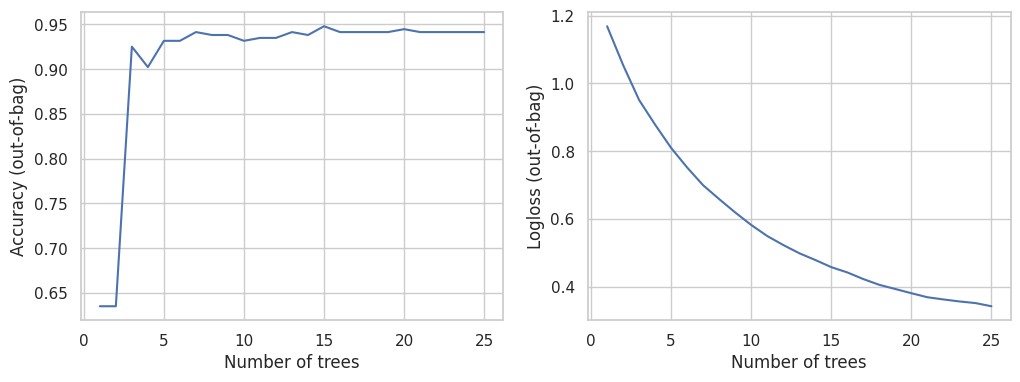

In [83]:
# Plot the training logs
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

Now we use tensorflow confusion matrix.   
It computes the confusion matrix from predictions and labels.   
First we need to convert lists and arrays into input tensors. 

In [84]:
# Predicting class on test dataset
predictionsClass = (model_1.predict(test_ds) > 0.5).astype("int32")

# Extract labels tensor from tensorflow dataset and convert it to numpy
XTensor, labelsTensor = tuple(zip(*test_ds))
# X = np.array(XTensor)
labelsArr = np.array(labelsTensor)
labelsArr = np.reshape(labelsArr, (labelsArr.size,))

# Extract predictions list from results of the model and convert it to numpy
predictionsArr = np.array([predictionsClass[i][0] for i in range(len(predictionsClass))])

1/1 [==============================] - 0s 51ms/step


In [85]:
# Initializing the input tensor from numpy arrays
labels = tf.constant(labelsArr,dtype = tf.int32)
predictions = tf.constant(predictionsArr,dtype = tf.int32)
 
# Printing the input tensor
print('Labels: ',labels)
print('Predictions: ',predictions)
 
# Evaluating confusion matrix
res = tf.math.confusion_matrix(labels, predictions)
 
# Printing the result
print('\n----------------------\n')
print('Confusion_matrix: \n')
print(res)

Labels:  tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0], shape=(307,), dtype=int32)
Predictions:  tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 

The results of the confusion matrix reveal a very robust model with few false positive and negative values.

### Predicting samples
And finally, we are now going to use the model to predict whether the strawberry sample is pure or adulterated

In [89]:
# With the model trained, we will use it for predictions of tampering in the samples.

predictionsClass = (model_1.predict(test_ds) > 0.5).astype("int32")


def evaluateSample(sampleID):    
    resultClass = predictionsClass[sampleID][0]
    if resultClass == 1:
        print(f'Sample ID {sampleID} : Pure strawberry.')
    else:
        print(f'Sample ID {sampleID} : Adulterated strawberry.')

1/1 [==============================] - 0s 47ms/step


In [90]:
sampleID = 25
evaluateSample(sampleID)

Sample ID 25 : Pure strawberry.


In [91]:
sampleID = 20
evaluateSample(sampleID)

Sample ID 20 : Pure strawberry.


# Conclusion
The purpose of this notebook was  to create a classifier model for detection of 
adulteration in strawberry puree samples from its infrared spectra (FT-IR), using tensorflow decision forest algorithm.   
The work showed that with the Gradient Boosted Trees Model we obtained an excellent accuracy greater than 0.9 for the classification of adulteration.  
In order to make our features more suitable, we demonstrated the use of tensorflow autoencoder network to reduce infrared spectrum dimensionality.  
In addition, as a didactic proposal, we showed how to distribute the autoencoder training across multiple GPUs, using tensorflow tf.distribute.Strategy and also how to transform our pandas dataframe into a tensorflow dataset, using the tf.data.Dataset abstraction.

I hope you enjoyed the work. Any doubts we are available and any errors or suggestions for improvement please let us know.   
See you, bye.


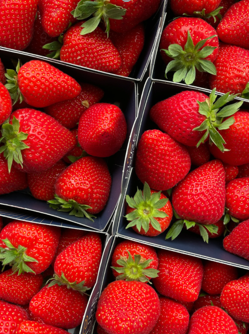  

Photo by <a href="https://unsplash.com/@rmithare?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Raghavendra Mithare</a> on <a href="https://unsplash.com/s/photos/strawberries?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

# References

Holland, J. K., Kemsley, E. K., & Wilson, R. H. (1998). Use of Fourier transform infrared spectroscopy and partial least squares regression for the detection of adulteration of strawberry purees. Journal of the Science of Food and Agriculture, 76(2), 263-269  
Dataset from http://csr.quadram.ac.uk/wp-content/uploads/MIRFruitPurees.zip   
https://www2.chemistry.msu.edu/faculty/reusch/virttxtjml/spectrpy/infrared/infrared.htm  
https://en.wikipedia.org/wiki/Infrared_spectroscopy  
https://en.wikipedia.org/wiki/Autoencoder#Dimensionality_reduction  
https://en.wikipedia.org/wiki/Autoencoder  
https://www.tensorflow.org/tutorials/generative/autoencoder  
https://www.tensorflow.org/guide/distributed_training#use_tfdistributestrategy_with_keras_modelfit  
https://www.tensorflow.org/guide/data#consuming_csv_data   
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#introduction  
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#prepare_this_model_for_tensorflow_serving  
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab#hyper-parameters   